## Libraries

In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import momepy
import os
import networkx as nx
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


At each step (i.e. with the creation of each unimodal network), need to keep track of two things: <br>
1. link IDs for each link
1. the network topology, so which two nodes are connected by the link ID

## Helper functions

In [2]:
# nodes_type_list is list of tuples of form [(nodes_df, node_color, node_label)]
def plot_nodes_and_edges(node_type_list, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1, label='edges')
    for n in node_type_list:
        n[0].plot(ax=ax, color = n[1], label = n[2], zorder=2)
    ax.legend()
    return ax

In [3]:
# add a column for the node's position in the form used by networkx. 
# note: this is only useful when converting from geopandas df to networkx graph
def nx_pos(x, y):
    return {'pos': (x,y)}

In [4]:
# convert from gpd df to networkx graph object
# input: df of nodes
# output: networkx graph with nodes and positions. note: edges still need to be added to complete the graph structure
def to_nx_graph(nodes_df):
    graph_nodes = list(zip(nodes_df.ID.tolist(), nodes_df.nx_pos.tolist()))
    G = nx.DiGraph()
    G.add_nodes_from(graph_nodes)
    return G

In [5]:
# prune the edges of the edge df
# eliminates edges that connect nodes which are not members of the graph
# return graph edges in the proper form, ready to be added to the networkx graph
def prune_edges(G, edges_df):
    edges_df_subset = edges_df[(edges_df['N1'].isin(G.nodes)) & (edges_df['N2'].isin(G.nodes))]
    graph_edges = list(zip(edges_df_subset['N1'].tolist(), edges_df_subset['N2'].tolist(),
                       edges_df_subset['attr'].tolist()))
    return graph_edges

In [6]:
def nx_edge_attr(linkID, speed):
    attr_dict = {'linkID': linkID, 'speed':speed}
    return attr_dict

In [7]:
def nx_edge_attr(attr_name, attr_var):
    return {attr_name: attr_var}

In [8]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [9]:
def relabel_nodes(G, prefix):
    new_nodename = [prefix+str(i) for i in G.nodes]
    namemap = dict(zip(G.nodes, new_nodename))
    G = nx.relabel_nodes(G, namemap, True)
    return G

In [10]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
# input: single point, multipoint (collection of many nodes)
# output: the node in multipoint that is nearest to the input single point
def near(input_point, base_nodes_df):
    multipoint = base_nodes_df.geometry.unary_union
    nn_geom = nearest_points(input_point, multipoint)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn_geom)  # nearest neighbor distance 
    # find the ID (w.r.t the base network) of the nearest neighbor 
    idx = base_nodes_df['geometry'] == nn_geom
    nn_ID = base_nodes_df[idx]['ID'].to_numpy()[0]
    return (nn_geom, nn_ID, dist)

In [213]:
def draw_graph(G, node_color, node_cmap, edge_color):
    # draw the graph in networkx
    node_coords = nx.get_node_attributes(G, 'pos')    
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G, pos=node_coords, with_labels=True, font_color='white', font_size=8,  font_weight = 'bold',
            node_size=500, node_color=node_color, edge_color=edge_color, arrowsize=16, ax=ax)
    # add legend for node color    
    inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
    for v in set(inv_node_cmap.keys()):
        ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'upper right')
    return ax

## Pittsburgh Road Network Data

In [12]:
cwd = os.getcwd() 
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

In [13]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/SPC_GIS/')
new_dir
os.chdir(new_dir)

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/SPC_GIS/'

In [14]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [15]:
nodes = read_file("new_node.shp")
edges = read_file("new_link.shp")

In [16]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

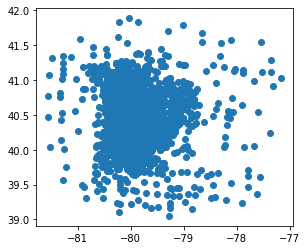

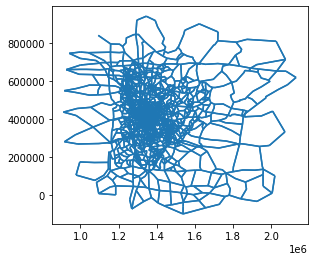

In [17]:
nodes.plot()
#nodes.crs
edges.plot()

## "Clip" the data: subset PGH road network by selected neighborhoods

In [18]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)


<AxesSubplot:>

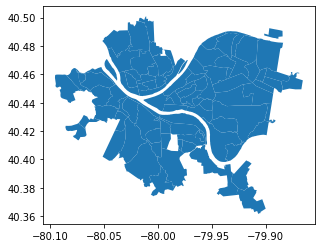

In [19]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [20]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
#hood_keep = [ 'Central Oakland', 'North Oakland']  # smaller list for testing
hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty', "Central Oakland", 'North Oakland', 'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
              'Glen Hazel'] #'Westwood', 'Crafton Heights', 'Sheraden', 'Windgap', 'Fairywood']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

226

<AxesSubplot:>

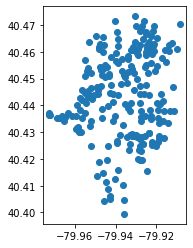

In [21]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

680

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
1727,1000076,903,5191,15,7,0.02,1,1000076,1357939.908,397980.474,1357039.909,397790.472,"LINESTRING (-79.94263 40.40503, -79.94584 40.4..."
9982,76,5191,903,15,7,0.02,1,76,1357039.909,397790.472,1357939.908,397980.474,"LINESTRING (-79.94584 40.40444, -79.94263 40.4..."
5612,2705,2953,903,35,1,0.01,0,2705,1357853.486,398376.302,1357939.908,397980.474,"LINESTRING (-79.94297 40.40611, -79.94263 40.4..."
1725,1002705,903,2953,35,1,0.01,0,1002705,1357939.908,397980.474,1357853.486,398376.302,"LINESTRING (-79.94263 40.40503, -79.94297 40.4..."
5610,1002697,2953,5866,35,1,0.02,0,1002697,1357853.486,398376.302,1357681.264,399290.222,"LINESTRING (-79.94297 40.40611, -79.94367 40.4..."


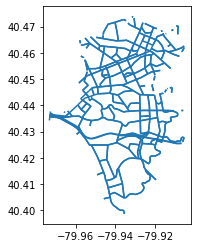

In [22]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

<AxesSubplot:>

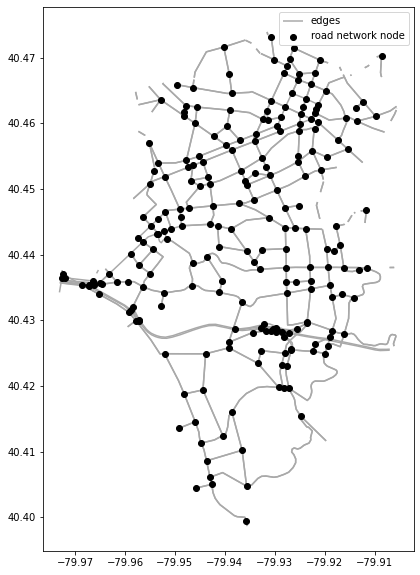

In [23]:
plot_nodes_and_edges([(nodes_clip, 'black', 'road network node')], edges_clip)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.25,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."


<AxesSubplot:>

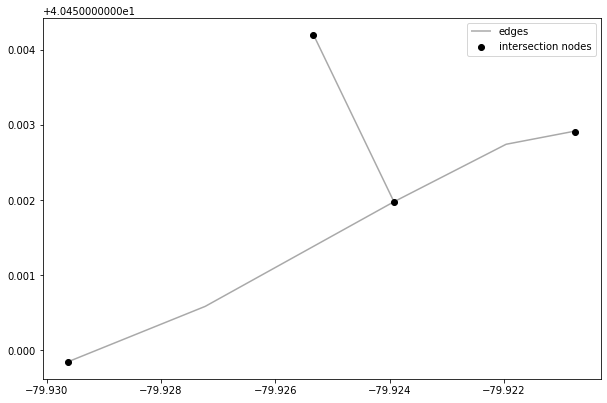

In [24]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32', 'linkID':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

plot_nodes_and_edges([(nclip_test, 'black', 'intersection nodes')], eclip_test)
# this plot confirms that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [25]:
nodes_clip.loc[27]['geometry'].x
nodes_clip.loc[27]['geometry'].y

-79.923923

40.451967

In [28]:
edges_clip.head(3)
# redefine the linkIDs such that they correspond to the row number. not sure if this will mess things up yet
edges_clip.reset_index(inplace=True)
edges_clip['linkID'] = edges_clip.index
edges_clip.head()

,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,1727,0,903,5191,15,7,0.02,1,1000076,1357939.908,397980.474,1357039.909,397790.472,"LINESTRING (-79.94263 40.40503, -79.94584 40.4..."
1,9982,1,5191,903,15,7,0.02,1,76,1357039.909,397790.472,1357939.908,397980.474,"LINESTRING (-79.94584 40.40444, -79.94263 40.4..."
2,5612,2,2953,903,35,1,0.01,0,2705,1357853.486,398376.302,1357939.908,397980.474,"LINESTRING (-79.94297 40.40611, -79.94263 40.4..."


,level_0,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,0,1727,0,903,5191,15,7,0.02,1,1000076,1357939.908,397980.474,1357039.909,397790.472,"LINESTRING (-79.94263 40.40503, -79.94584 40.4..."
1,1,9982,1,5191,903,15,7,0.02,1,76,1357039.909,397790.472,1357939.908,397980.474,"LINESTRING (-79.94584 40.40444, -79.94263 40.4..."
2,2,5612,2,2953,903,35,1,0.01,0,2705,1357853.486,398376.302,1357939.908,397980.474,"LINESTRING (-79.94297 40.40611, -79.94263 40.4..."
3,3,1725,3,903,2953,35,1,0.01,0,1002705,1357939.908,397980.474,1357853.486,398376.302,"LINESTRING (-79.94263 40.40503, -79.94297 40.4..."
4,4,5610,4,2953,5866,35,1,0.02,0,1002697,1357853.486,398376.302,1357681.264,399290.222,"LINESTRING (-79.94297 40.40611, -79.94367 40.4..."


## Convert geopandas df to networkx graph
### Because the small network test code was written using the networkx graph object

In [29]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry'], dtype='object')

In [30]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
nodes_clip.columns

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_pos'], dtype='object')

In [31]:
nodes_clip.head(3)

,ID,isOD,geometry,x,y,nx_pos
3719,5188,0,POINT (-79.93569 40.39946),-79.935685,40.399455,"{'pos': (-79.935685, 40.399455)}"
3720,5191,1,POINT (-79.94584 40.40443),-79.945838,40.404434,"{'pos': (-79.945838, 40.404434)}"
3516,4918,0,POINT (-79.93565 40.40474),-79.935646,40.404738,"{'pos': (-79.935646, 40.404738)}"


In [32]:
# add nodes to the graph, including their positions 
G_base = to_nx_graph(nodes_clip)
G_base.nodes[37]['pos']

(-79.923923, 40.451967)

In [34]:
edges_clip['attr'] = edges_clip.apply(lambda e: nx_edge_attr('speed', e['spd']), axis=1)
#edges_clip['nx_linkID'] = edges_clip.apply(lambda e: nx_edge_attr('link_ID', e['linkID']), axis=1)
#edges_clip['attr'] = edges_clip.apply(lambda e: merge(e['nx_speed'], e['nx_linkID']), axis=1)
edges_clip.head(2)

,level_0,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,0,1727,0,903,5191,15,7,0.02,1,1000076,1357939.908,397980.474,1357039.909,397790.472,"LINESTRING (-79.94263 40.40503, -79.94584 40.4...",{'speed': '15'}
1,1,9982,1,5191,903,15,7,0.02,1,76,1357039.909,397790.472,1357939.908,397980.474,"LINESTRING (-79.94584 40.40444, -79.94263 40.4...",{'speed': '15'}


In [35]:
# only include edges if the nodes they connect are also in the nodes of the graph
graph_edges = prune_edges(G_base, edges_clip)
graph_edges[:3]

[(903, 5191, {'speed': '15'}),
 (5191, 903, {'speed': '15'}),
 (2953, 903, {'speed': '35'})]

In [36]:
# add edges to the graph, including their speed limit
G_base.add_edges_from(graph_edges)
len(G_base.nodes)

226

Text(0.5, 1.0, 'Base Road Map for Selected Neighborhoods')

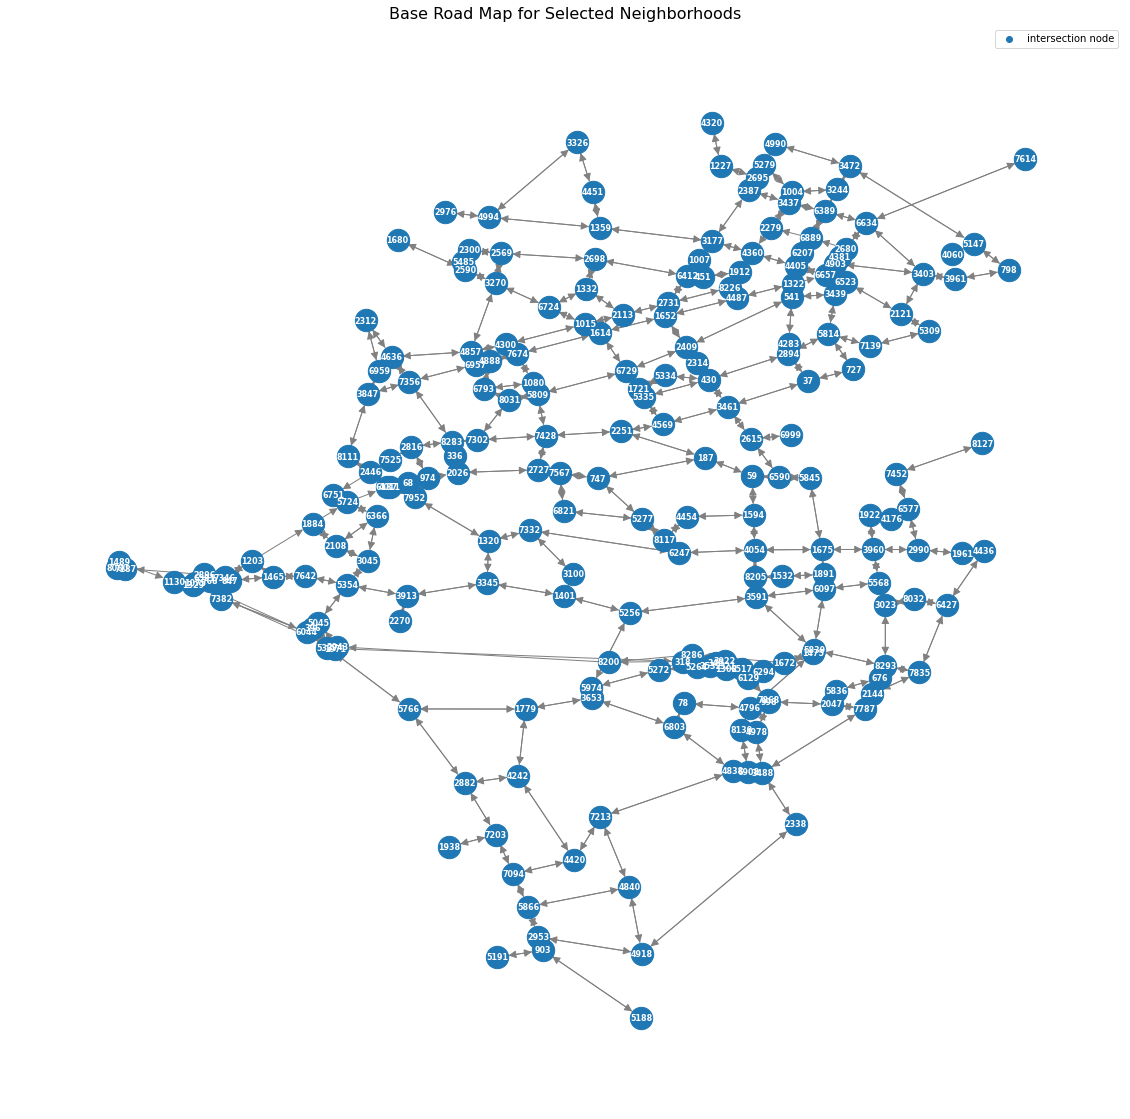

In [214]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_base, '#1f77b4', node_cmap, edge_color='gray')
ax.set_title('Base Road Map for Selected Neighborhoods', fontsize=16)

## TNC
The TNC graph is assumed to be the same as the base road network

In [87]:
G_tnc = G_base.copy()
G_tnc = relabel_nodes(G_tnc, 't')

In [96]:
def set_link_IDs(G, prev_max_linkID):
    num_links = G.size()
    linkIDs = [i for i in range(prev_max_linkID+1, prev_max_linkID+1 + num_links)]
    a = dict(zip(G.edges, linkIDs))
    attr = {key: {'link_ID':val} for key, val in a.items()}
    nx.set_edge_attributes(G, attr)  

In [97]:
set_link_IDs(G_tnc, -1)
#test = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
#test

589

In [98]:
G_tnc['t5188']['t903']

{'speed': '35', 'link_ID': 0}

## Personal Vehicle 

### Park and Ride Data

In [46]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/ParkRide')
os.chdir(new_dir)
file_name = 'SPCRegPNR.shp'   # https://data.wprdc.org/dataset/regional-park-n-ride-facilities-web-inventory/resource/46692b9c-ad3f-4a29-8deb-5ca4207eb50d
pnr_gdf = read_file(file_name)
pnr_gdf.head(2)
#pnr_gdf.crs
# Transform geometry of edges to the proper coord system
pnr_gdf = pnr_gdf.to_crs(epsg = 4326)
#pnr_gdf.crs

,ID,STATUS,NAME,LOCATION,MUNIC,ZIPCITY,ZIPCODE,COUNTY,X_COORD,Y_COORD,RESTRICT_,CAPACITY,OWNER,PARK_FEE,D_PARK_FEE,M_PARK_FEE,SERV_TRANS,TRANS_OP_1,TRANS_OP_2,geometry
0,1.0,OPEN,OLYMPIA SHOPPING CENTER-WALNUT ST-MCKEESPORT,4313 WALNUT ST.,CITY OF MCKEESPORT,MCKEESPORT,15132,ALLEGHENY,40.32270,-79.83461,TRANSIT ONLY,50,PRIVATE,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1387303.979 367272.753)
1,2.0,OPEN,DUQUESNE-LIBRARY PL AT DUQUESNE BLVD-DUQUESNE,RT 837 (DUQUESNE BLVD.) AT LIBRARY PL.,CITY OF DUQUESNE,DUQUESNE,15110,ALLEGHENY,40.37227,-79.84466,NONE,311,PORT AUTHORITY OF ALLEGHENY COUNTY,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1384930.811 385392.023)


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

(0, 20)

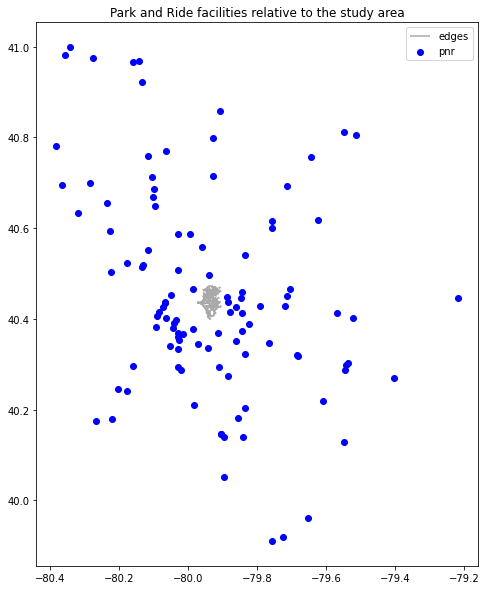

In [47]:
ax = plot_nodes_and_edges([(pnr_gdf, 'blue', 'pnr')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
# observe that no park and ride facilities intersect the study area...
# confirmation:
pnr_clip = gpd.clip(pnr_gdf, pgh_nhoods_mask)
pnr_clip.shape

Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

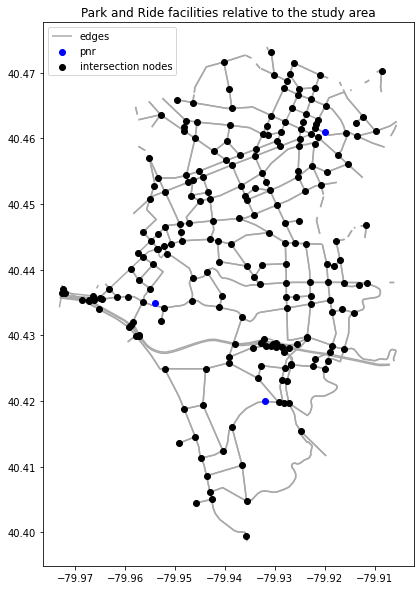

In [48]:
# for testing, i have chosen to create three fake pnr facilities located within study area
# randomly choose three nodes that are spead out in the road network
pnr1 = (-79.954, 40.435)
pnr2 = (-79.92, 40.461)
pnr3 = (-79.932, 40.42)
pnr_coords = [pnr1, pnr2, pnr3]
# build Points from these coords
point_list = [Point(c[0], c[1]) for c in pnr_coords]
new_pnr_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(point_list), crs='EPSG:4326')
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')

### Create edges from Park and Ride stations to nearest node neighbor in the road network

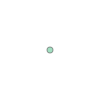

In [49]:
new_pnr_gdf['geometry'].iloc[0]

In [50]:
from sklearn.neighbors import BallTree

In [51]:
a, b, c = near(new_pnr_gdf['geometry'][0], nodes_clip)
print(a,b,c)
new_pnr_gdf.head()
type(new_pnr_gdf)

POINT (-79.95222099999999 40.434248) 3913 0.0019314101066332933


,geometry
0,POINT (-79.95400 40.43500)
1,POINT (-79.92000 40.46100)
2,POINT (-79.93200 40.42000)


geopandas.geodataframe.GeoDataFrame

In [52]:
# find the intersection node in the road network that is nearest to the pnr station
new_pnr_gdf[['nn_geom','nn_ID','nn_dist']] = new_pnr_gdf.apply(lambda row: near(row['geometry'], nodes_clip), axis=1).tolist()
# add attributes necessary for convesion to nx.graph
new_pnr_gdf['x'] = new_pnr_gdf['geometry'].x
new_pnr_gdf['y'] = new_pnr_gdf['geometry'].y
new_pnr_gdf['nx_pos'] = new_pnr_gdf.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
new_pnr_gdf.insert(loc=0, column='ID', value=np.arange(len(new_pnr_gdf)))
new_pnr_gdf.head()
# add linestring beween each pnr facility and its nn (for graphing)
pnr_geom_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in new_pnr_gdf.iterrows()]
pnr_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(pnr_geom_edges), crs='EPSG:4326')
# these edges will be explicitly added to the networkx graph structure

/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Applications/anaconda

,ID,geometry,nn_geom,nn_ID,nn_dist,x,y,nx_pos
0,0,POINT (-79.95400 40.43500),POINT (-79.95222099999999 40.434248),3913,0.001931,-79.954,40.435,"{'pos': (-79.954, 40.435)}"
1,1,POINT (-79.92000 40.46100),POINT (-79.9213 40.460154),6523,0.001551,-79.920,40.461,"{'pos': (-79.92, 40.461)}"
2,2,POINT (-79.93200 40.42000),POINT (-79.929237 40.419784),4838,0.002771,-79.932,40.420,"{'pos': (-79.932, 40.42)}"


Text(0.5, 1.0, 'Park and Ride facilities relative to the study area')

<AxesSubplot:title={'center':'Park and Ride facilities relative to the study area'}>

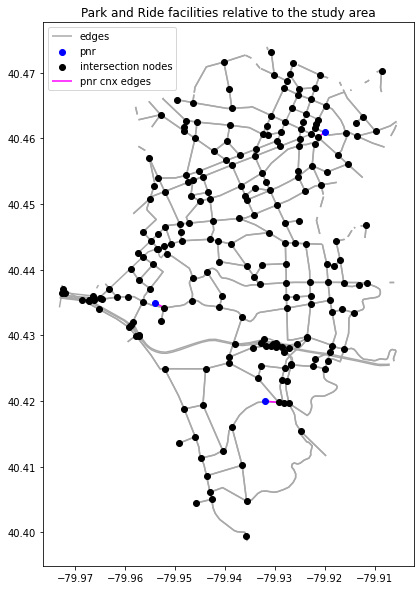

In [53]:
ax = plot_nodes_and_edges([(new_pnr_gdf, 'blue', 'pnr'), (nodes_clip, 'black', 'intersection nodes')], edges_clip)
ax.set_title('Park and Ride facilities relative to the study area')
pnr_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='pnr cnx edges')
ax.legend()

### Convert to networkx graph object

In [206]:
# create graph structure 
# start with base road network
G_pv = G_base.copy()
G_pv = relabel_nodes(G_pv, 'pv')

In [207]:
G_pv.edges['pv5188', 'pv903']

{'speed': '35'}

In [208]:
# convert pnr nodes to nx graph and then merge with road network
G_pnr = to_nx_graph(new_pnr_gdf)
G_pnr = relabel_nodes(G_pnr, 'k')
G_pv = nx.union_all([G_pv, G_pnr])   # merge the intersection nodes with the pnr stations

In [209]:
# add edges from pnr station to the road map in order to connect the network
new_pnr_gdf['nodeID'] = new_pnr_gdf.apply(lambda row: 'k'+str(row['ID']), axis=1)
new_pnr_gdf['nn_nodeID'] = new_pnr_gdf.apply(lambda row: 'pv'+str(row['nn_ID']), axis=1)
edges_out = list(zip(new_pnr_gdf['nodeID'], new_pnr_gdf['nn_nodeID']))
edges_in = list(zip(new_pnr_gdf['nn_nodeID'], new_pnr_gdf['nodeID']))
G_pv.add_edges_from(edges_out + edges_in)  

In [210]:
# add link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_tnc, 'link_ID').values()))
prev_max_linkID
set_link_IDs(G_pv, prev_max_linkID)

589

Text(0.5, 1.0, 'Personal Vehicle Network')

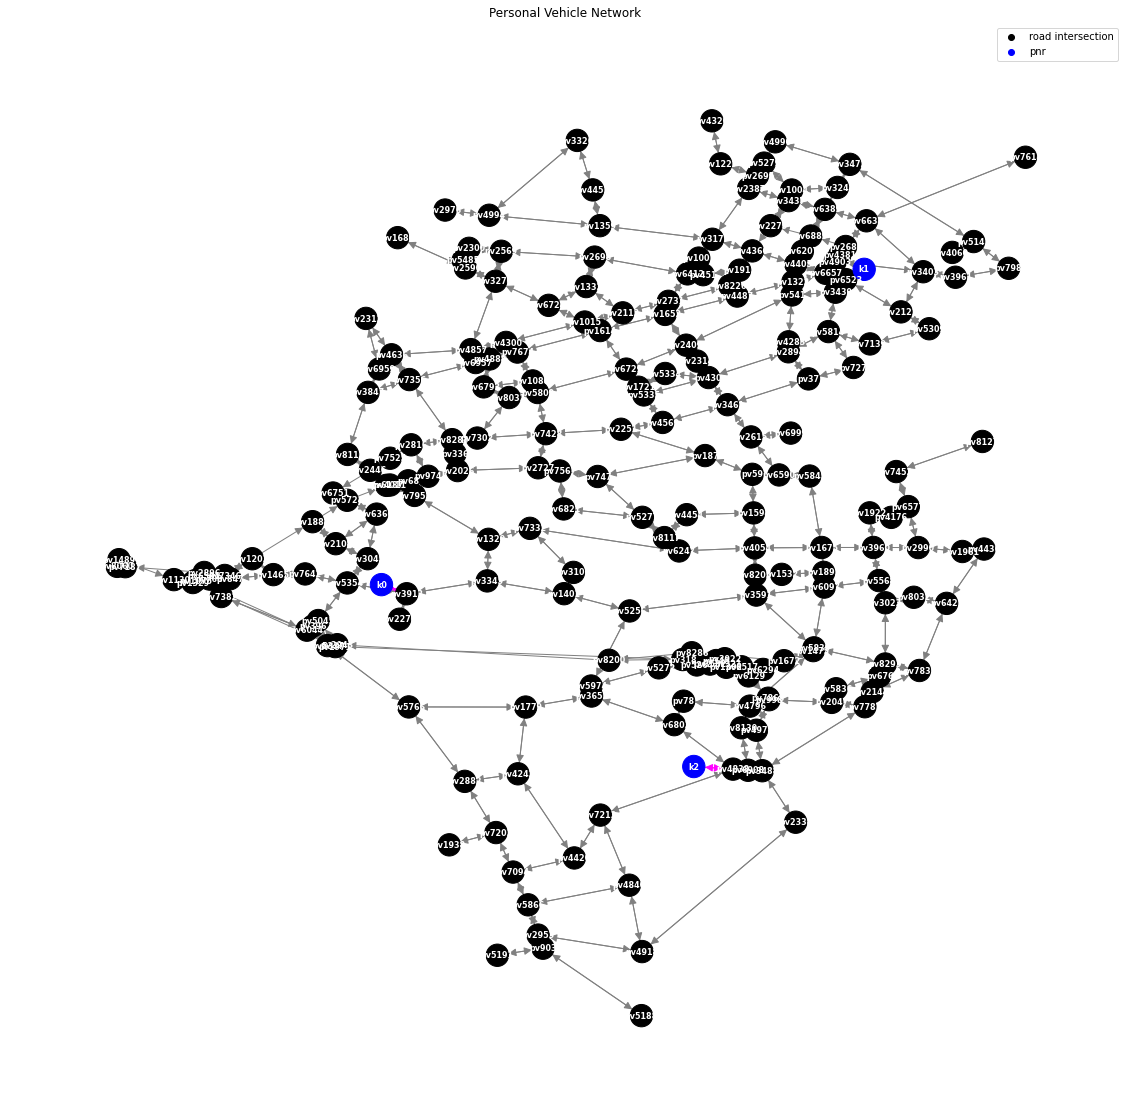

In [221]:
node_color = ['black' if n.startswith('pv') else 'blue' for n in G_pv.nodes]
edge_color = ['grey' if e[0].startswith('pv') and e[1].startswith('pv') else 'magenta' for e in G_pv.edges]
ax = draw_graph(G_pv, node_color, {'road intersection':'black', 'pnr':'blue'}, edge_color)
ax.set_title('Personal Vehicle Network')

**Summary up to this point** <br>
We began with the base road network node/link shapefile, which contained intersection nodes and road links. This was converted into the networkx graph object after some data processing. The nodes have IDs and position attributes, and the links have IDs and speed limit attributes. The unimodal TNC network was taken to be an exact copy of the base road network. The personal vehicle network was then constructed as an exact copy of the base road network with two additions: 1) park + ride station nodes, and 2) park + ride connector edges. Connector edges are edges that join the station to the nearest road intersection node. It is necessary to construct these connector edges because the park and ride station nodes may not exactly intersect a road network node. It is also important to note that each unimodal network is associated with distinct node and link IDs; although the networks overlap in the physical world, they are considered unique in our model. Distinct node and link IDS are required to solve the multimodal shortest path problem.

## Personal Bike

In its simplest form, the personal bike network consists of the base road network, where only the street segments with a speed limit less than 40 mph (subject to change) are retained. We may also think about adding off-road bike paths. Furthermore, it will be useful to download the bike lane shapefile at some point, as this will be used to assess segment safety.

In [230]:
# Start with the original road network
# Then find the "bike-friendly" streets, i.e. those with a speed limit <= 40
bike_speedlim_max = 40
edges_clip['spd'] = edges_clip['spd'].astype('float')
bike_edges_clip = edges_clip[edges_clip['spd'] <= bike_speedlim_max]
edges_clip.shape
bike_edges_clip.shape  # only slight reduction in roads with a max speed limit of 40...could lower the max speed limit if desired
# Find the nodes that interesect the bike-friendly streets (in the clipped network)
nodes_keep = list(set(bike_edges_clip.N1.tolist() + bike_edges_clip.N2.tolist()))
bike_nodes_clip = nodes_clip[nodes_clip.ID.isin(nodes_keep)]
bike_edges_clip.head(2)

(680, 16)

(655, 16)

,level_0,index,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
0,0,1727,0,903,5191,15.0,7,0.02,1,1000076,1357939.908,397980.474,1357039.909,397790.472,"LINESTRING (-79.94263 40.40503, -79.94584 40.4...",{'speed': '15'}
1,1,9982,1,5191,903,15.0,7,0.02,1,76,1357039.909,397790.472,1357939.908,397980.474,"LINESTRING (-79.94584 40.40444, -79.94263 40.4...",{'speed': '15'}


In [ ]:
def prune_edges(G, edges_df):
    edges_df_subset = edges_df[(edges_df['N1'].isin(G.nodes)) & (edges_df['N2'].isin(G.nodes))]
    graph_edges = list(zip(edges_df_subset['N1'].tolist(), edges_df_subset['N2'].tolist(),
                       edges_df_subset['attr'].tolist()))
    return graph_edges

In [242]:
G_pb = to_nx_graph(bike_nodes_clip)
pruned_edges = prune_edges(G_pb, bike_edges_clip)
prefix = 'pb'
graph_edges = [(prefix + str(e[0]), prefix + str(e[1]), e[2]) for e in pruned_edges]
G_pb = relabel_nodes(G_pb, prefix) # rename nodes
G_pb.add_edges_from(graph_edges)
# set link IDs
prev_max_linkID = max(list(nx.get_edge_attributes(G_pv, 'link_ID').values()))
set_link_IDs(G_pb, prev_max_linkID)
G_pb.size()

573

Text(0.5, 1.0, 'Personal Bike Network for Selected Neighborhoods')

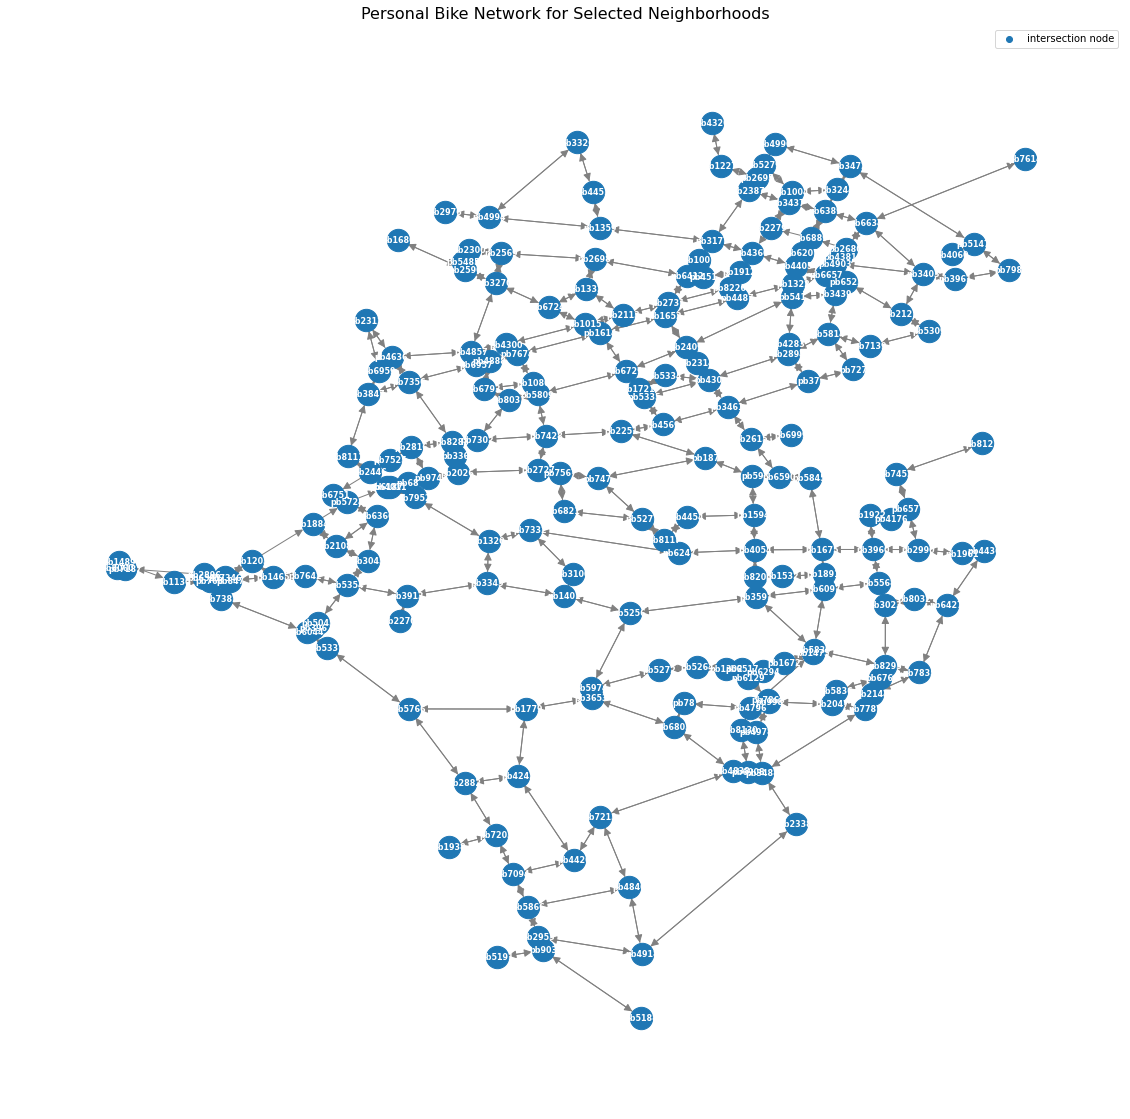

In [243]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_pb, '#1f77b4', node_cmap, edge_color='gray')
ax.set_title('Personal Bike Network for Selected Neighborhoods', fontsize=16)

## Bikeshare

**Get bikeshare Data**

In [57]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations

In [145]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

In [146]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St,9,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


In [147]:
# add position column, to be used when converting to networkx graph object
bs_df['nx_pos'] = bs_df.apply(lambda p: nx_pos(p['Longitude'], p['Latitude']), axis=1)

**Convert to geo df and clip to selected neighborhoods**

<AxesSubplot:>

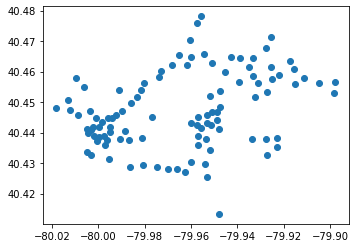

In [148]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df
bs_gdf.plot()

<AxesSubplot:>

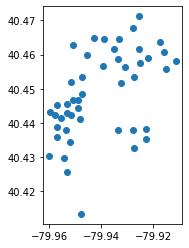

In [149]:
# Clip the bs node network
bs_depots_clip = gpd.clip(bs_gdf, pgh_nhoods_mask)
bs_depots_clip.plot()

<AxesSubplot:>

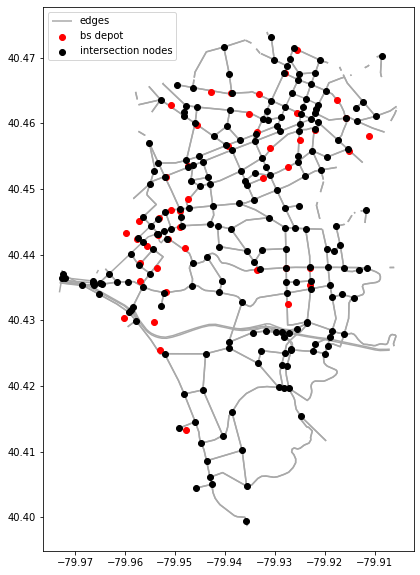

In [151]:
plot_nodes_and_edges([(bs_depots_clip, 'red', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Application

,Station #,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
76,49201,Lytle St & Eliza St,10,40.413316,-79.947789,"{'pos': (-79.94778872, 40.41331634)}",POINT (-79.94779 40.41332),POINT (-79.949223 40.413541),1938,0.001452
67,1085,Eliza Furnace Trail at Swinburne St,8,40.425552,-79.952981,"{'pos': (-79.95298147, 40.42555209)}",POINT (-79.95298 40.42555),POINT (-79.95207499999999 40.424914),5766,0.001109
69,1088,Frazier St & Dawson St,5,40.429685,-79.954140,"{'pos': (-79.95414019, 40.42968463)}",POINT (-79.95414 40.42968),POINT (-79.952727 40.432146),2270,0.002838
37,1038,Boulevard of the Allies & Parkview Ave,19,40.434338,-79.951877,"{'pos': (-79.951877, 40.434338)}",POINT (-79.95188 40.43434),POINT (-79.95222099999999 40.434248),3913,0.000356
43,1044,Zulema St & Coltart Ave,19,40.435986,-79.956942,"{'pos': (-79.956942, 40.435986)}",POINT (-79.95694 40.43599),POINT (-79.956411 40.43514),5354,0.000999


In [ ]:
# data: 
# 1) bike_nodes_clip: intersection nodes
# 2) bike_edges_clip: road nodes
# 3) bs_depots_clip: depot nodes

**Create edge from bikeshare depot to nearest network node** <br>
This is the same procedure as what was used for the park and ride stations

In [171]:
bs_depots_clip[['nn_geom', 'nn_ID', 'nn_dist']] = bs_depots_clip.apply(lambda row: near(row['geometry'], bike_nodes_clip), axis=1).tolist()
bs_depots_clip.head()
# add linestring beween each pnr facility and its nn (for graphing)
depot_cnx_edges = [LineString([row['geometry'], row['nn_geom']]) for i, row in bs_depots_clip.iterrows()]
depot_cnx_edges_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(depot_cnx_edges), crs='EPSG:4326')
depot_cnx_edges_gdf.head()

,geometry
0,"LINESTRING (-79.94779 40.41332, -79.94922 40.4..."
1,"LINESTRING (-79.95298 40.42555, -79.95207 40.4..."
2,"LINESTRING (-79.95414 40.42968, -79.95273 40.4..."
3,"LINESTRING (-79.95188 40.43434, -79.95222 40.4..."
4,"LINESTRING (-79.95694 40.43599, -79.95641 40.4..."


<AxesSubplot:>

Text(0.5, 1.0, 'Bikeshare Network')

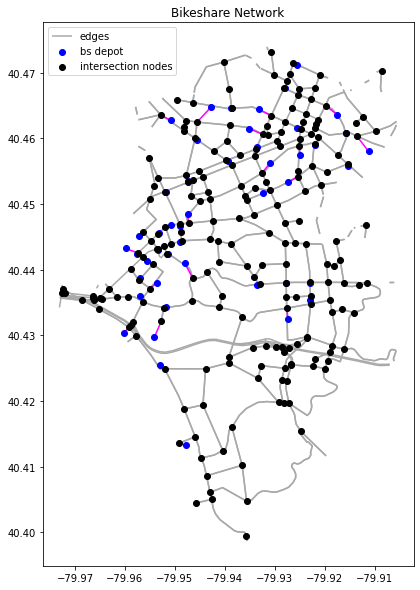

In [173]:
ax = plot_nodes_and_edges([(bs_depots_clip, 'blue', 'bs depot'), (bike_nodes_clip, 'black', 'intersection nodes')], edges_clip)
depot_cnx_edges_gdf.plot(ax=ax, color = 'magenta', zorder=1, label='depot cnx edges')
ax.set_title('Bikeshare Network')

### Convert to networkx graph

In [175]:
# add intersection nodes and rename
G_bs = G_pb.copy()  
G_bs = relabel_nodes(G_bs, 'bs')

In [178]:
# add depot nodes with IDs
bs_depots_clip.rename(columns={'Station #': 'ID'}, inplace=True)
bs_depots_clip.head()
G_bs_depots = to_nx_graph(bs_depots_clip)
G_bs = relabel_nodes(G_bs, 'bsd')
# merge the graphs

# add the depot cnx edges

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ID,Station Name,# of Racks,Latitude,Longitude,nx_pos,geometry,nn_geom,nn_ID,nn_dist
76,49201,Lytle St & Eliza St,10,40.413316,-79.947789,"{'pos': (-79.94778872, 40.41331634)}",POINT (-79.94779 40.41332),POINT (-79.949223 40.413541),1938,0.001452
67,1085,Eliza Furnace Trail at Swinburne St,8,40.425552,-79.952981,"{'pos': (-79.95298147, 40.42555209)}",POINT (-79.95298 40.42555),POINT (-79.95207499999999 40.424914),5766,0.001109
69,1088,Frazier St & Dawson St,5,40.429685,-79.954140,"{'pos': (-79.95414019, 40.42968463)}",POINT (-79.95414 40.42968),POINT (-79.952727 40.432146),2270,0.002838
37,1038,Boulevard of the Allies & Parkview Ave,19,40.434338,-79.951877,"{'pos': (-79.951877, 40.434338)}",POINT (-79.95188 40.43434),POINT (-79.95222099999999 40.434248),3913,0.000356
43,1044,Zulema St & Coltart Ave,19,40.435986,-79.956942,"{'pos': (-79.956942, 40.435986)}",POINT (-79.95694 40.43599),POINT (-79.956411 40.43514),5354,0.000999


In [ ]:
# only include edges if the nodes they connect are also in the nodes of the graph
G_bs_edges = prune_edges(G_bs, bike_edges_clip)
G_bs.add_edges_from(G_bs_edges)

In [ ]:
node_color = ['black' if depot == 'N' else 'blue' for depot in nx.get_node_attributes(G_bs, 'isDepot').values()]
node_cmap = {'intersection node':'black', 'depot node':'blue'}
draw_graph(G_bs, node_color, node_cmap)

In [ ]:
# Note that in the figure of nodes_clip and edges_clip, there are some detached roads. Let's only include a fully connected network
nodes_included = nodes_clip['ID'].tolist()
node_mask = edges_clip['N1'].isin(nodes_included) | edges_clip['N2'].isin(nodes_included)
new_edges_clip = edges_clip[node_mask]
len(new_edges_clip)
plot_nodes_and_edges(nodes_clip, new_edges_clip)